In [218]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from random import randint
import json

In [219]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
data = pd.read_csv('/content/drive/MyDrive/datasets/data_ds.csv')
users = pd.read_csv('/content/drive/MyDrive/datasets/users_ds.csv')
items = pd.read_csv('/content/drive/MyDrive/datasets/items_ds.csv')

In [221]:
print(data.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [235]:
#encode title and release date
item_enc = LabelEncoder()
items['title_enc'] = item_enc.fit_transform(items['title'].values)
rel_enc = LabelEncoder()
items['release_enc'] = rel_enc.fit_transform(items['release'].values)
items = items.drop(['release'], axis=1)

items.head(3)

,item_id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_enc,release_enc
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1523,69
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,616,69
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,553,69


In [224]:
full_data = pd.merge(data, items)

rec = []
for i in range(len(data)):
  if (full_data['rating'][i] > 3):
    rec.append(1)
  else:
    rec.append(0)
full_data['recommended'] = rec
full_data.head(3)

,user_id,item_id,rating,timestamp,title,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_enc,release_enc,recommended
0,196,242,3,881250949,Kolya (1996),0,0,0,0,0,...,0,0,0,0,0,0,0,825,193,0
1,63,242,3,875747190,Kolya (1996),0,0,0,0,0,...,0,0,0,0,0,0,0,825,193,0
2,226,242,5,883888671,Kolya (1996),0,0,0,0,0,...,0,0,0,0,0,0,0,825,193,1


In [225]:
#create separate dataset
#for each user with set of rated movies

datasets = dict()
for user in range(1, len(users)+1):
  df = pd.DataFrame(columns=['unknown','Action', 'Adventure','Animation',
                             "Children's", 'Comedy', 'Crime','Documentary',
                             'Drama','Fantasy','Film-Noir','Horror', 'Musical',
                             'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
                             'Western','title_enc', 'release_enc',
                             'recommended',  'rating'])
  datasets[user] = df

for row in range(len(full_data)):
  user = full_data['user_id'][row]
  new_row = []
  for col in full_data.columns[5:]:
    new_row.append(full_data[col][row])
  new_row.append(full_data['rating'][row])
  datasets[user].loc[len(datasets[user])] = new_row

In [226]:
tree_set = dict()
for user in range(1, len(users)+1):
  clf_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 100,
                                    max_depth = 3, min_samples_leaf = 5)
  tree_set[user] = clf_tree

In [ ]:
#check, how good model can predict user's reting
#hide 10% movies in each user and try to predict ratings
#evaluation - RMSE

In [227]:
#train & test

predictions = dict()

for user in range(1, len(users)+1):
  X = datasets[user].drop(['recommended',  'rating'], axis=1)
  y = datasets[user]['rating'].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,
                                                      random_state = 100)
  tree_set[user].fit(X_train, y_train)
  y_pred = tree_set[user].predict(X_test)
  predictions[user] = (y_test, y_pred)

In [ ]:
#look, how average result depend of amount of train set

In [228]:
result = dict()
for user in range(1, len(users)+1):
  sz = len(datasets[user])
  if (sz in result):
    result[sz] += mean_squared_error(predictions[user][0], predictions[user][1])**0.5
  else:
    result[sz] = mean_squared_error(predictions[user][0], predictions[user][1])**0.5

average RMSE = 0.08249232980342763


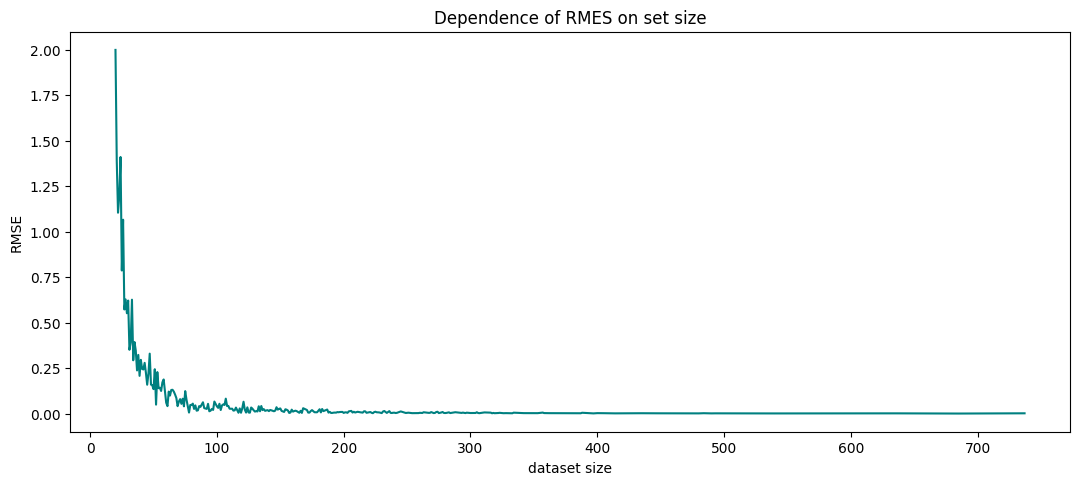

In [233]:
x_ax = list(result.keys())
x_ax.sort()
y_ax = []
for sz in x_ax:
  y_ax.append(result[sz] / sz)

fig = plt.figure(figsize =(10, 4))
ax = fig.add_axes([1, 1, 1, 1])
ax.plot(x_ax, y_ax, color='teal')
plt.title("Dependence of RMES on set size")
plt.xlabel('dataset size')
plt.ylabel('RMSE')
plt.savefig('cont_bas_result.png', bbox_inches='tight')

print(f"average RMSE = {np.mean(y_ax)}")
plt.show()